In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import random
from datetime import datetime, timedelta
from shapely.geometry import Point
from busSim import BusSim

In [2]:
DATA_PATH = "./data"
DAY = "monday"
START_TIME = "12:00:00"
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4  # 1.4 meters per second
MAX_WALKING_MIN = 10

In [3]:
def fmin(minutes):
    return f"{minutes // 60}:{minutes % 60}:00"

# doesn't account for time span across 2 days (not implement for across bus schedule: weekday -> weekend)
def every_time(interval, elapse_time):
    start_times = []
    curr = 0
    min_total = 24 * 60 - elapse_time
    while curr <= min_total:
        start_times.append(fmin(curr))
        curr += interval

    return start_times

In [10]:
start_times = every_time(10, 30)
for t in start_times:
    print("---------------------------------------------------------")
    # t0 = time.time()
    busSim = BusSim(DATA_PATH, DAY, t, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
    t1 = time.time()
    gdf = busSim.get_gdf(start_point=(43.073691, -89.387407))
    t2 = time.time()
    busSim.get_area(gdf)
    t3 = time.time() 

---------------------------------------------------------
2021-02-04 18:14:54,237 - INFO - Start initializing sim
2021-02-04 18:14:54,238 - DEBUG - Start generating dataframe
2021-02-04 18:14:55,160 - DEBUG - start generating graph
2021-02-04 18:14:55,161 - DEBUG - generated 0 nodes in the graph
2021-02-04 18:14:55,162 - INFO - Sim successfully initialized
2021-02-04 18:14:55,169 - INFO - Start searching graph
---------------------------------------------------------
2021-02-04 18:14:55,171 - INFO - Start initializing sim
2021-02-04 18:14:55,172 - DEBUG - Start generating dataframe
2021-02-04 18:14:56,042 - DEBUG - start generating graph
2021-02-04 18:14:56,043 - DEBUG - generated 0 nodes in the graph
2021-02-04 18:14:56,044 - INFO - Sim successfully initialized
2021-02-04 18:14:56,045 - INFO - Start searching graph
---------------------------------------------------------
2021-02-04 18:14:56,046 - INFO - Start initializing sim
2021-02-04 18:14:56,046 - DEBUG - Start generating datafra

KeyboardInterrupt: 

In [9]:
start_times = every_time(10, 30)
perf = pd.DataFrame()

ts = time.time()
for t in start_times:
    # print(t)
    # t0 = time.time()
    busSim = BusSim(DATA_PATH, DAY, t, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
    t1 = time.time()
    gdf = busSim.get_gdf(start_point=(43.073691, -89.387407))
    t2 = time.time()
    busSim.get_area(gdf)
    t3 = time.time() 
    # perf.loc[t, "graph-gen"] = t1 - t0
    perf.loc[t, "graph-search"] = t2 - t1
    perf.loc[t, "calc-area"] = t3 - t2
    perf.loc[t, "total"] = t3 - t1
    perf.loc[t, "nodes-num"] = len(busSim.graph.nodes)

te = time.time()
perf

,graph-search,calc-area,total,nodes-num
0:0:00,0.000005,1.192093e-06,0.000006,0.0
0:10:00,0.000005,9.536743e-07,0.000006,0.0
0:20:00,0.000007,9.536743e-07,0.000008,0.0
0:30:00,0.000005,9.536743e-07,0.000006,0.0
0:40:00,0.000008,9.536743e-07,0.000009,0.0
...,...,...,...,...
22:50:00,0.279344,5.459609e-01,0.825305,612.0
23:0:00,0.254807,5.057929e-01,0.760600,421.0
23:10:00,0.246626,4.533491e-01,0.699975,204.0
23:20:00,0.244123,4.557540e-01,0.699877,66.0


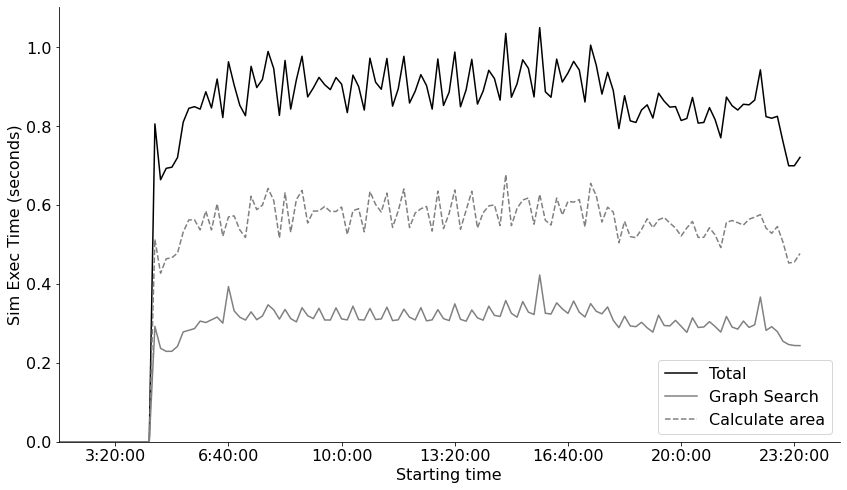

In [12]:
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(figsize=(14,8))
perf["total"].plot.line(ax=ax, label="Total", color="k", xlim=10, ylim=0)
perf["graph-search"].plot.line(ax=ax, label="Graph Search", color="0.5")
perf["calc-area"].plot.line(ax=ax, label="Calculate area", color="0.5", linestyle="--")
ax.set_xlabel("Starting time")
ax.set_ylabel("Sim Exec Time (seconds)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend()

2162.0

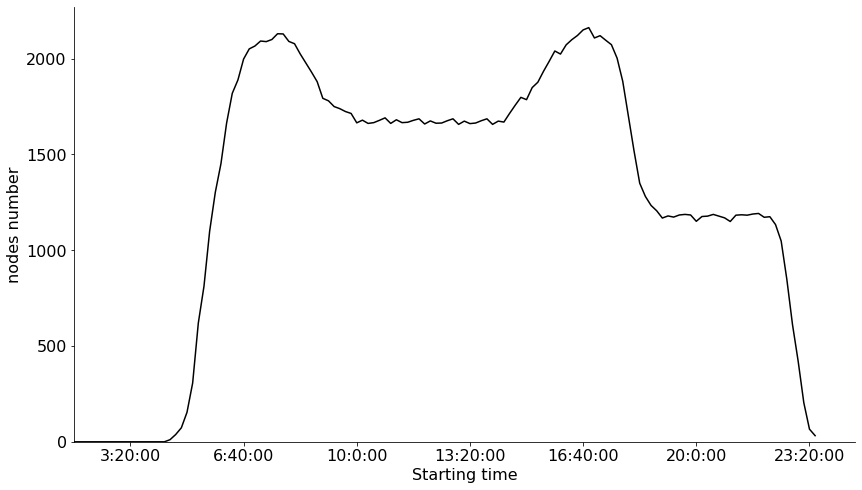

In [13]:
fig, ax = plt.subplots(figsize=(14,8))
perf["nodes-num"].plot.line(ax=ax, label="nodes number", color="k", xlim=10, ylim=0)
ax.set_xlabel("Starting time")
ax.set_ylabel("nodes number")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

perf["nodes-num"].max()

In [11]:
def gen_locations(num):
    mmt_gtfs_path = os.path.join(DATA_PATH, "mmt_gtfs")
    stops_df = pd.read_csv(os.path.join(
        mmt_gtfs_path, "stops.csv"), sep=",")
    locations = []

    lat_min = stops_df.stop_lat.min()
    lat_max = stops_df.stop_lat.max()
    lon_min = stops_df.stop_lon.min()
    lon_max = stops_df.stop_lon.max()

    for i in range(num):
        lat = random.random() * (lat_max - lat_min) + lat_min
        lon = random.random() * (lon_max - lon_min) + lon_min
        locations.append((lat, lon))

    return locations

In [14]:
t0 = time.time()
busSim = BusSim(DATA_PATH, DAY, "10:00:00", ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
t1 = time.time()
for location in gen_locations(10):
    print("--------------------------------------------------------------")
    gdf = busSim.get_gdf(start_point=(location[0], location[1]))
    busSim.get_area(gdf)
t2 = time.time()

2021-02-04 18:17:47,608 - INFO - Start initializing sim
2021-02-04 18:17:47,610 - DEBUG - Start generating dataframe
2021-02-04 18:17:48,570 - DEBUG - start generating graph
2021-02-04 18:17:49,876 - DEBUG - generated 1665 nodes in the graph
2021-02-04 18:17:49,877 - INFO - Sim successfully initialized
--------------------------------------------------------------
2021-02-04 18:17:49,897 - INFO - Start searching graph
2021-02-04 18:17:49,898 - DEBUG - start locating starting stop
2021-02-04 18:17:49,907 - DEBUG - start clearing graph
2021-02-04 18:17:49,908 - DEBUG - start runnning dijkstra
2021-02-04 18:17:49,909 - DEBUG - start collecting nodes
2021-02-04 18:17:49,910 - DEBUG - start generating df
2021-02-04 18:17:49,915 - DEBUG - start generating gdf
2021-02-04 18:17:49,960 - DEBUG - start finding centriod
2021-02-04 18:17:49,961 - DEBUG - start changing encoding to 3174
2021-02-04 18:17:50,102 - DEBUG - start generating geometry buffer with radius
2021-02-04 18:17:50,104 - DEBUG - 